In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# What is overfitting and is it as bad as they say?

In [ ]:
''' Over fitting
- Overly sensitive to noise
- Increased sensitivity to subtle effects
- Reduced generalizability
- Over-parameterized models become difficult to estimate

Under fitting
- Less sensitive to noise
- Less likely to detect true effects
- Reduced generalizability (Ability to predict new data(model hasn't seen before))
- Parameters are better estimated
- Good results with less data

* How to know the correct number of parameters?
- Use cross-validation

* How to avoid overfitting
1) Use cross-validation (training/hold-out/test sets).
2) Use regularization (L2, drop-out, data manipulations, early stopping).

* Hidden overfitting: "reasearcher degrees of freedom"
- The researcher has many choices for how to clean, organize, and select the data;
and which models and how many models to run.

Example: Test models A, B, and C on the same data. Go back and clean the data again with different criteria,
then test the three models again. Publish model B with re-cleaned data, which worked best on the test set.

* How to avoid researcher overfitting
1) Decide on the model architecture in advance, and make only minor adjustments.
Feasible for frequently-studied problems.
2) Build a series of models but never use the test set until all models are trained (kaggle-like competition).
Best for new problems or new models.
'''

# Cross-validation

In [ ]:
''' Cross-validation

- 80% Training set: Train the model on these data
- 10% Hold-out (dev) set: Test model on these data (w.o. training) -> adapt

- 10% Test set

* Does cross-validation really prevent overfitting?
- Crucial assumption of cross-validation: The hold-out and test sets are independent of (uncorrelated with) the training set.
- Example of assumption validity: Train a model to label pictures of pets as 'cat', 'dog', 'bird', or 'wallabee'.
Test set is pictures taken by people whose pictures were not in the training or hold-out sets.

Example of assumption violation: Train a model to predict age based on pictures of people's faces.
Test set is pictures of their siblings.

Example of assumption violation: Train a model to predict marker value of homes.
Training set is randomly selected homes in a city. Test set is homes next door.

* Conclusion: Overfitting is not intrinsically bad; overfitting reduces generalizability,
which may or may not be problematic depending on the goals and scope of the model.
'''

# Generalization

In [ ]:
''' Generalization and its boundaries

* Generalization: The model works well when applied to new data.
* Generalization boundaries: The population you want to apply the model to.

Generalization and accuracy
- Generalization entails some loss of accuracy!
- The trick is to build a model that does well within the generalization boundaries.
- Decide your generalization boundaries carefully.
- Have examples from those populations in the training/hold-out/test sets.
'''

# Cross-validation -- manual separation

In [2]:
iris = sns.load_dataset('iris', cache=False)

data = torch.tensor(iris[iris.columns[:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Seperate data into train and test

In [3]:
# how many training examples
propTraining = .8 # in proportion, not percent
nTraining = int(len(labels)*propTraining)

# initialize a boolean vector to select data and labels
traintestBool = np.zeros(len(labels), dtype=bool)

# random sample
items2use4train = np.random.choice(range(len(labels)), nTraining, replace=False)
traintestBool[items2use4train] = True

traintestBool

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
        True,  True,

In [4]:
# test whether it's balanced
print('Average of full data:')
print(torch.mean(labels.float()))
print()

print('Average of training data:')
print(torch.mean(labels[traintestBool].float()))
print()

print('Average of test data:')
print(torch.mean(labels[~traintestBool].float()))

Average of full data:
tensor(1.)

Average of training data:
tensor(1.0167)

Average of test data:
tensor(0.9333)


In [5]:
# create the ANN model

# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3),
)

lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)

In [6]:
# enire dataset
print(data.shape)

# training set
print(data[traintestBool, :].shape)

# test set
print(data[~traintestBool, :].shape)

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


## Train and test the model

In [7]:
# train the model
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

    # forward pass
    yHat = ANNiris(data[traintestBool, :])

    # compute accuracy
    ongoingAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==labels[traintestBool]).float()).item() )

    # compute loss
    loss = lossfunc(yHat, labels[traintestBool])
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
# compute train and test accuracies

# final forward pass USING TRAINING DATA
predictions = ANNiris(data[traintestBool, :])
train_acc = 100 * torch.mean((torch.argmax(predictions, axis=1) == labels[traintestBool]).float()).item()

# final forward pass USING TEST DATA!
predictions = ANNiris(data[~traintestBool, :])
test_acc = 100 * torch.mean((torch.argmax(predictions, axis=1)==labels[~traintestBool]).float()).item()

In [9]:
# report accuracies

print('Final TRAIN accuracy: %g%%' %train_acc)
print('Final TEST accuracy: %g%%' %test_acc)

Final TRAIN accuracy: 98.3333%
Final TEST accuracy: 100%


# Cross-validation -- scikitlearn

In [ ]:
''' Why an 80/20 split?
- General idea: Have as much training data as possible, while still have enough holdout and test data.
- How much is "enough"? Depends on the data, model architecture, generalizability, etc.

- HUGE dataset - 98/1/1 split : IMAGENET 14,197,122 images
'''

In [15]:
# a function that creates the ANN model
def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)

    return ANNiris, lossfunc, optimizer

In [16]:
# train the model

# global parameter
numepochs = 200

def trainTheModel(trainProp):

    # seperate train from test data
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = trainProp)

    # initialize losses
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass and loss
        yHat = ANNiris(X_train)
        loss = lossfunc(yHat, y_train)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute training accuracy
        trainAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y_train).float()).item() )

        # test accuracy
        predlabels = torch.argmax( ANNiris(X_test), axis=1 )
        testAcc.append( 100 * torch.mean((predlabels==y_test).float()).item() )

    return trainAcc, testAcc

## Test the model by running it once

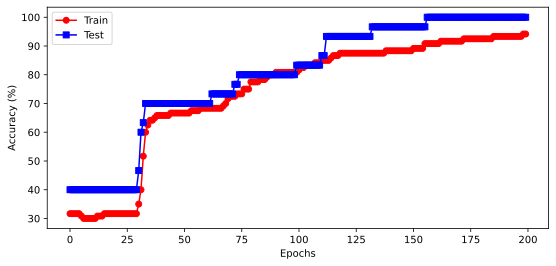

In [17]:
# create a model
ANNiris, lossfunc, optimizer = createANewModel()

# train the model
trainAcc, testAcc = trainTheModel(.8)

# plot the results
fig = plt.figure(figsize=(9,4))

plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.show()

## Now for the experiment

In [18]:
trainSetSizes = np.linspace(.2,.95,10)

trainSetSizes

array([0.2       , 0.28333333, 0.36666667, 0.45      , 0.53333333,
       0.61666667, 0.7       , 0.78333333, 0.86666667, 0.95      ])

In [19]:
allTrainAcc = np.zeros((len(trainSetSizes), numepochs))
allTestAcc = np.zeros((len(trainSetSizes), numepochs))

for i in range(len(trainSetSizes)):

    # create a model
    ANNiris, lossfunc, optimizer = createANewModel()

    # train the model
    trainAcc, testAcc = trainTheModel(trainSetSizes[i])

    # store the results
    allTrainAcc[i, :] = trainAcc
    allTestAcc[i, :] = testAcc

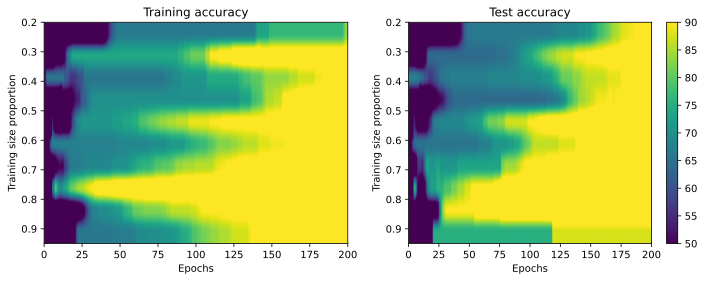

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(allTrainAcc, aspect='auto', vmin=50, vmax=90, extent=[0,numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc, aspect='auto', vmin=50, vmax=90, extent=[0,numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p, ax=ax[1])

plt.show()

# Cross-validation -- DataLoader

In [21]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=.8)

# then convert them into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
train_loader = DataLoader(trainset, shuffle=True, batch_size=12)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


In [22]:
X, y

(tensor([[5.7000, 3.0000, 4.2000, 1.2000],
         [6.3000, 2.5000, 5.0000, 1.9000],
         [6.5000, 3.0000, 5.2000, 2.0000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [4.9000, 2.5000, 4.5000, 1.7000],
         [6.1000, 2.9000, 4.7000, 1.4000],
         [4.9000, 3.1000, 1.5000, 0.2000],
         [6.7000, 3.1000, 4.7000, 1.5000],
         [5.0000, 3.4000, 1.6000, 0.4000],
         [6.9000, 3.1000, 5.4000, 2.1000],
         [6.7000, 3.1000, 4.4000, 1.4000],
         [4.9000, 3.6000, 1.4000, 0.1000]]),
 tensor([1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 0]))

In [23]:
# a function that creates the ANN model
def createANewModel():

    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)

    return ANNiris, lossfunc, optimizer

In [24]:
# train the model

numepochs = 500

def trainTheModel():

    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute accuracy
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    return trainAcc, testAcc

## Modeling

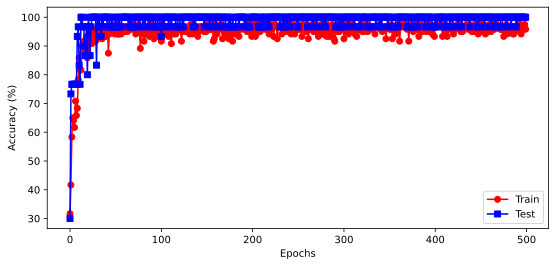

In [27]:
# create a model
ANNiris, lossfunc, optimizer = createANewModel()

# train the model
trainAcc, testAcc = trainTheModel()

# plot the results
fig = plt.figure(figsize=(9,4))

plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])

# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

# Splitting data into train, devset, test

In [28]:
# create fake dataset
fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4

print(fakedata)
print()
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]

[False False False False False  True  True  True  True  True]


## Usint train_test_split

In [29]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [.8,.1,.1]

# split the data (note the third input, and the TMP in the variable name)
train_data, testTMP_data, train_labels, testTMP_labels = \
    train_test_split(fakedata, fakelabels, train_size=partitions[0])

# now split the TMP data
split = partitions[1] / np.sum(partitions[1:])

val_data, test_data, val_labels, test_labels = \
    train_test_split(testTMP_data, testTMP_labels, train_size=split)

# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Validation data size: ' + str(val_data.shape))
print('Test data size: ' + str(test_data.shape))
print()

# print out the train/test data
print('Training data:')
print(train_data)
print()

print('Validation data:')
print(val_data)
print()

print('Test data:')
print(test_data)

Training data size: (8, 4)
Validation data size: (1, 4)
Test data size: (1, 4)

Training data:
[[ 21  22  23  24]
 [ 81  82  83  84]
 [ 51  52  53  54]
 [ 11  12  13  14]
 [ 61  62  63  64]
 [ 31  32  33  34]
 [ 71  72  73  74]
 [101 102 103 104]]

Validation data:
[[41 42 43 44]]

Test data:
[[91 92 93 94]]


## Splitting the data manually using numpy

In [30]:
# partition sizes in proportion
partitions = np.array([.8,.1,.1])
print('Partition proportions:')
print(partitions)
print()

# convert those into integers
partitionBnd = np.cumsum(partitions*len(fakelabels)).astype(int)
print('Partition boundaries:')
print(partitionBnd)
print()

# random indices
randindices = np.random.permutation(range(len(fakelabels)))
print('Randomized data indices:')
print(randindices)

Partition proportions:
[0.8 0.1 0.1]

Partition boundaries:
[ 8  9 10]

Randomized data indices:
[7 5 3 6 0 8 4 2 1 9]


In [31]:
# select rows for the training data
train_dataN = fakedata[randindices[:partitionBnd[0]], :]
train_labelsN = fakelabels[randindices[:partitionBnd[0]]]

# select rows for the val data
val_dataN = fakedata[randindices[partitionBnd[0]:partitionBnd[1]], :]
val_labelsN = fakelabels[randindices[partitionBnd[0]:partitionBnd[1]]]

# select rows for the test data
test_dataN = fakedata[randindices[partitionBnd[1]:], :]
test_labelsN = fakelabels[randindices[partitionBnd[1]:]]

In [32]:
# print out the sizes
print('Training data size: ' + str(train_dataN.shape))
print('Validation data size: ' + str(val_dataN.shape))
print('Test data size: ' + str(test_dataN.shape))

Training data size: (8, 4)
Validation data size: (1, 4)
Test data size: (1, 4)


In [33]:
print('Train data:')
print(train_dataN)
print()

print('Validation data:')
print(val_dataN)
print()

print('Test data:')
print(test_dataN)

Train data:
[[81 82 83 84]
 [61 62 63 64]
 [41 42 43 44]
 [71 72 73 74]
 [11 12 13 14]
 [91 92 93 94]
 [51 52 53 54]
 [31 32 33 34]]

Validation data:
[[21 22 23 24]]

Test data:
[[101 102 103 104]]


# Cross-validation on regression

## Create the data and the model

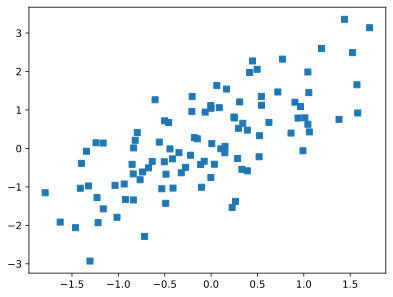

In [66]:
N = 100
x = torch.randn(N,1)
y = x + torch.randn(N,1)

# and plot
plt.plot(x,y,'s')
plt.show()

In [67]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(1,1),
    nn.ReLU(),
    nn.Linear(1,1)
)

# model meta-parameters
learningRate = .1

lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learningRate)

## Select data for training

In [68]:
# select training data (note the hard-coded N!)
trainidx = np.random.choice(range(N), 80, replace=False) # random indices
trainBool = np.zeros(N, dtype=bool) # initialize vector of Falses'
trainBool[trainidx] = True # set selected samples to True

# show the sizes
print(x[trainBool].shape)
print(x[~trainBool].shape)

torch.Size([80, 1])
torch.Size([20, 1])


## Train the model

In [69]:
numepochs = 500
for epochi in range(numepochs):

    # forward pass
    yHat = ANNreg(x[trainBool])

    # compute loss
    loss = lossfunc(yHat, y[trainBool])

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [70]:
# compute losses of the TEST set
predYtest = ANNreg(x[~trainBool])
testloss = (predYtest-y[~trainBool]).pow(2).mean()

# print out final TRAIN loss and TEST loss
print(f'Final TRAIN loss: {loss.detach():.2f}')
print(f'Final TEST loss: {testloss.detach():.2f}')

Final TRAIN loss: 0.74
Final TEST loss: 0.58


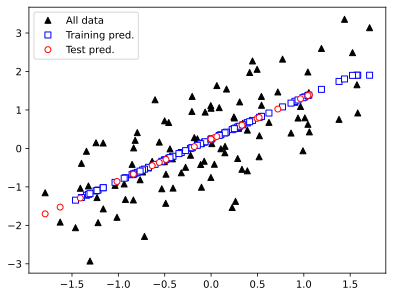

In [71]:
# plot the data

# predictions for final training run
predYtrain = ANNreg(x[trainBool]).detach().numpy()

# now plot
plt.plot(x,y, 'k^', label='All data')
plt.plot(x[trainBool], predYtrain, 'bs', markerfacecolor='w', label='Training pred.')
plt.plot(x[~trainBool], predYtest.detach(), 'ro', markerfacecolor='w', label='Test pred.')
plt.legend()
plt.show()